# Forward modeling diffusion of Sr in plagioclase

Jordan Lubbers<br>
Alaska Volcano Observatory<br>

This notebook walks through how to forward model Sr in plagioclase using the partitioning model of [Dohmen and Blundy (2014)](https://ajsonline.org/article/65642) as well as the solution to the diffusion equation put forth in the appendix of [Dohmen et al., (2017)](https://pubs.geoscienceworld.org/msa/rimg/article/83/1/535/520738/Chronometry-and-Speedometry-of-Magmatic-Processes).

It relies heavily on the functions found in the [`plag_diff.py`](https://github.com/jlubbersgeo/diffusion_chronometry/blob/main/plag_diff.py) module. 

General outline:
1. Look at our observed data
2. Calculate a quasi steady state profile
3. Calculate an initial model condition
4. Forward model diffusion and find a best fit to the observed data
5. Randomize some variables to quantify timescale uncertainty

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import plag_diff as plag



In [2]:
data = pd.read_excel(
    r"C:\Users\jlubbers\OneDrive - DOI\Research\Phd_research\Writing\Toba_manuscript\Toba_supplementary_all.xlsx",
    sheet_name="plagioclase trace profiles",
).set_index('grain')



## Observed data
- Sr profile
- X<sub>An</sub> profile

Text(0.8, 1.03, 'Rim')

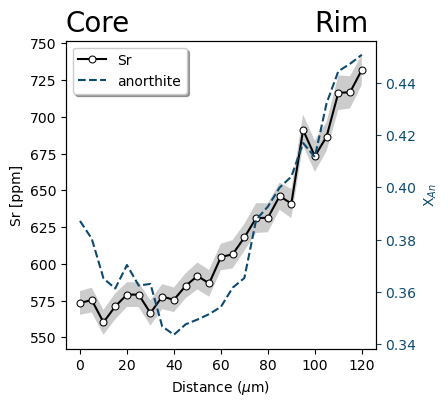

In [3]:
# specify which grain to use
grain = "MQ3"

# specify which element to model
element = "Sr"

resolution = 5.0  # um

# for consistent colors throughout
obs_color = "#000000"  # observed data
# equilibrium data
dohmen_color = "#FF1F5B"
an_color = "#0D4A70"
init_color = "#A0B1BA"  # initial profile related data
bf_color = "#00CD6C"


# the domain you wish to model diffusion over
# try to keep this untouched but if there are
# erroneous ends on your data this will clip them
start =0
stop = 0


# unclipped data for a grain
# distance
dist_all = np.arange(0, data.loc[grain, :].shape[0]) * resolution
# measured trace element information
te_all = data.loc[grain, element].to_numpy()
te_unc_all = data.loc[grain, "{}_se".format(element)].to_numpy()
# anorthite
an_all = data.loc[grain, "An"].to_numpy()
if np.unique(an_all>1)[0] == True:
    an_all = an_all / 100
# clipped data. If above start and stop are 0 they
# will be the same as the unclipped data. This is fine.
te = te_all[start : len(te_all) - stop]
te_unc = te_unc_all[start : len(te_all) - stop]
dist = dist_all[start : len(te_all) - stop]
an = an_all[start : len(te_all) - stop]


# plot observed data
fig, ax = plt.subplots(figsize = (4,4))
# observed profile and subset
l1, = ax.plot(
    dist,
    te,
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    ms=5,
    mew=0.75,
    label=element,
)
ax.fill_between(dist, te + te_unc, te - te_unc, fc = obs_color, alpha=0.2)

ax2 = ax.twinx()
l2, = ax2.plot(
    dist,
    an,
    c=an_color,
    marker="",
    mfc="w",
    mec=an_color,
    ms=5,
    mew=0.75,
    ls = '--',
    label="anorthite",
)
ax2.tick_params(axis="y", which="both", colors=an_color)
ax2.set_ylabel("X$_{An}$", c=an_color)

ax.legend(handles = [l1,l2],fancybox = True, shadow = True)
# fig.legend(loc="best")

ax.set_ylabel("{} [ppm]".format(element), c=obs_color)
ax.tick_params(axis="y", which="both", colors=obs_color)
ax.set_xlabel("Distance ($\mu$m)")

ax.text(0,1.03,'Core',fontsize = 20,transform = ax.transAxes)
ax.text(0.8,1.03,'Rim',fontsize = 20,transform = ax.transAxes)



## Quasi steady state "equlibrium" profiles

Because Sr diffuses significantly faster than the chemical exchange diffusion of anorthite and albite, it will equilibrate over timescales such that the An profile can be thought of as immobile. Furthermore, because Sr flux is the result of of 1) diffusion in response to its own gradient 2) gradients in An (the chemical potential of Sr in plagioclase depends strongly on An content), this partial ("quasi") equilibrium state will be non-homogenous. The exact quasi equilibrium state depends on the compositional dependence of a given element. For Sr, that has an activity coefficient that increases with An content, the quasi equilibrium state will be inversely correlated with An content. 

Because crystals are typically open to exchange with the surrounding melt (external reservoir), the chemical potential of Sr is fixed at the crystal rim. With the understanding that it is the chemical potential that drives diffusion of Sr - not its concentration, when the chemical potential at any point along our transect matches the chemical potential at the rim we have reached a quasi steady state or equilibrium situation $\frac{\delta C}{\delta t} = 0$ (and subsequently $J_i(x) = J_{s}$) for that frozen An distribution. Becuase the flux of Sr in plagiocalse is described as:

$$
J_s = -D_{Sr}\frac{\delta C_{Sr}}{\delta x} + \frac{D_{Sr}C_{Sr}}{RT}A_{Sr}\frac{\delta X_{An}}{\delta x} = const.
$$

when $J_s=0$ due to the chemical potential being homogenous in the plagioclase:
$$
{C_{Sr}^{eq}}(x) = {C_{Sr}^{0}}\exp{\left[\frac{A_{Sr}}{RT}X_{An}(x)\right]}
$$

Where
$$
{C_{Sr}^{0}} = {C_{Sr}^{rim}}\exp{\left[\frac{-A_{Sr}}{RT}{X_{An}^{rim}}\right]}
$$

Here $A$ comes from the relationship that describes how the activity coefficient ($\gamma$) changes with $X_{An}$:

$$
-RTln({\gamma}) = AX_{An} + B
$$

Later on we will show that no matter how long we run our diffusion model for, the Sr profile will not deviate from the quasi equilibrium situation even though we may be at magmatic temperatures. Below we show:
- Left: our observed Sr profile with respect to the quasi equilibrium profile
- Right: our observed Sr vs X<sub>An</sub> data with respect to the quasi equilibrium Sr vs X<sub>An</sub> data. We also plot a curve (black dashed line) for the equilibrium trace element partitioning at our specified temperature and melt composition

Text(0.5, 0, 'X$_{An}$')

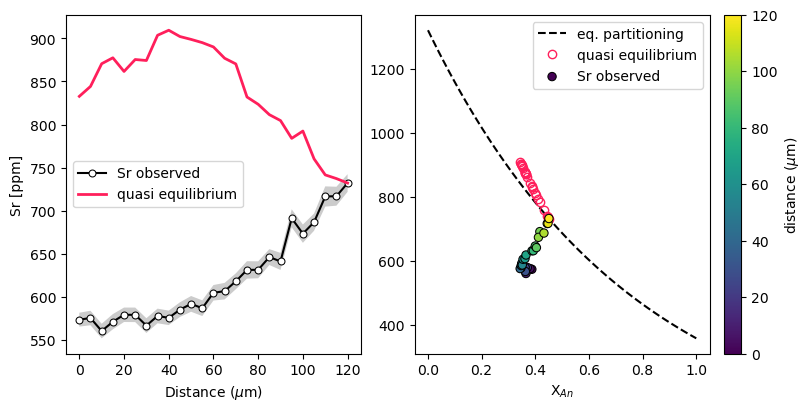

In [4]:
T = 750 #celsius
T_K = T + 273.15 #kelvin
R = 8.314 #J/molK
sio2_melt = 72 #wt%

RTlngamma, gamma, slope, intercept, stats = plag.dohmen_activity_calc(
    element, an, T, return_regression_stats=True
)

kd, rtlnk, A, B = plag.plag_kd_calc(
        element, an, T, method="Dohmen", sio2_melt=sio2_melt)

# range of anorthite compositions to calculate equilibrium curves
an_partition = np.linspace(0, 1,101)

# Calculated Mg equilibrium
kd_eq, rtlnk_eq, A_eq, B_eq = plag.plag_kd_calc(
    element, an_partition, T, method="Dohmen", sio2_melt=sio2_melt
)


c0 = te[-1] * np.exp(-slope*1000/(R*T_K)*an[-1])
eq_prof = c0 * np.exp(slope*1000/(R*T_K)*an)

Eq_solid_ave = te[-1] / kd[-1] * kd_eq



fig,ax = plt.subplots(1,2,figsize = (8,4),layout = 'constrained')

ax[0].plot(
    dist,
    te,
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    ms=5,
    mew=0.75,
    label=f"{element} observed",
)
ax[0].fill_between(dist, te + te_unc, te - te_unc, fc = obs_color, alpha=0.2)
ax[0].plot(dist,eq_prof,lw = 2, color = dohmen_color, label = 'quasi equilibrium')
ax[0].legend(loc = 'best')

ax[1].plot(an_partition, Eq_solid_ave, color='k', ls = '--', zorder = 0, label = 'eq. partitioning')
ax[1].plot(an,eq_prof,marker = 'o',ls = '',mfc = 'none',mec = dohmen_color,label = 'quasi equilibrium',zorder = 0)
s = ax[1].scatter(an, te, c=dist, ec='k', lw=0.75,label = f'{element} observed')
fig.colorbar(s, ax=ax[1], label='distance ($\mu$m)')
ax[1].legend(loc = 'upper right')


ax[0].set_ylabel(f"{element} [ppm]")
ax[0].set_xlabel('Distance ($\mu$m)')
ax[1].set_xlabel('X$_{An}$')



## Initial profile

This is probably one of the aspects of plagioclase diffusion modeling that introduces the most uncertainty. The basic premise of this is:
1. calculate a "melt equivalent" profile that based on the observed data. This is simply $C_l = \frac{C_s}{K_d}$ and represents the effective melt composition in equilibrium with the observed data. We make the assumption that some diffusion has occured between crystallization and eruption, and therefore this melt equivalent profile does NOT represent the melt composition at the time of crystallization. 
2. To approximate the melt composition at the time of plagioclase formation we take "melt equivalent" profile and simplify it back to a series of two or three discrete compositions that are based off changes in the An profile. Becuase the An component in plagioclase can effectively be treated as stationary in this scenario, it offers a good opportunity to view where changes in melt composition are happening. We then back calculate that simplified melt profile into plagioclase compositions that's in equilibrium with it to get our initial profile. An overall caveat of this methodology is that it necessitates that not much diffusion has occurred. If significant diffusion has occurred, creating simplified melt profiles off the observed data will not yield a melt profile that reflects the initial melt evolution during crystallization. We however, don't believe this is the case for our grains, due to the observed positive relationships between Sr and An. In brief, because Sr is compatible in plagioclase, this observed positive relationship generally means that little to no diffusive re-equilibration has occured in plagioclase (e.g.,Cooper and Kent, 2014). Further evidence to suggest that a positive correlation between Sr and X<sub>An</sub> reflects minimal diffusive equilibration is that the quasi equilibrium profile calculated above has a strong negative correlation and as diffusion progresses in the grain from initial profile to quasi equilibrium (shown later) this relationship goes from positive to negative.


    In the case where one is trying to model diffusion for a profile where it is assumed that the profile is close to quasi-equilibrium another method of estimating the initial profile would have to be used (e.g., creating a melt equivalent profile that mimics the shape and magnitude of the An profile changes, creating an initial profile that is effictively a "mirror" to the calculated equilibrium profile). More than any other assumption (and this goes for any study that forward models diffusion in plagioclase) the initial profile is probably the one that introduces the most uncertainty and we realize this, however, based on past reviewer comments in previous manuscripts, it was decided this was a sufficient way to go about it as creating an initial profile that is a simplified version of the observed plagioclase proflie (i.e., creating a solid profile step function) implicitly creates the situation whereby the melt profile would be extremely variable to keep the Sr profile the simplified shape. We do not believe we have the petrologic evidence to create such a melt profile and take an Occam's Razor approach in this case: a minimum number of input melt compositions is better.



Text(0.5, 0.01, 'Distance ($\\mu$m)')

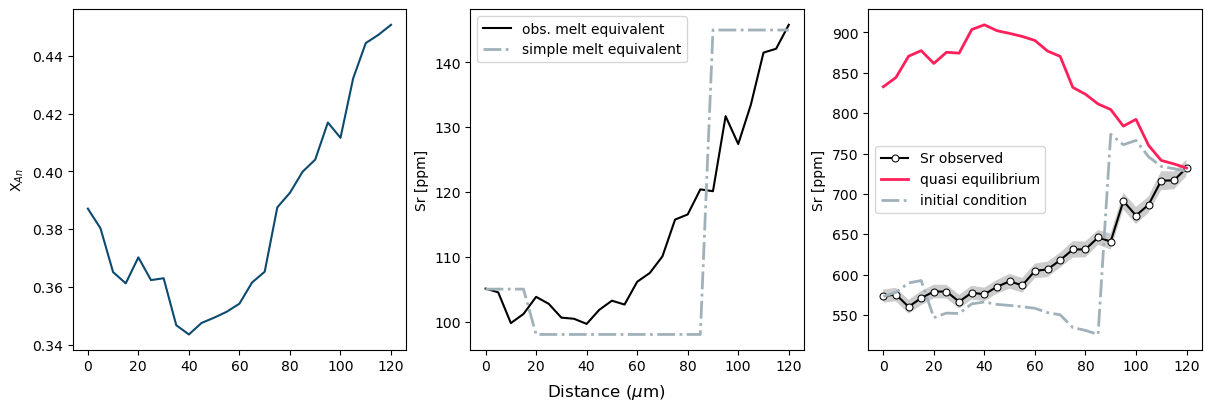

In [5]:
melt_equivalent = te / kd

simple_liquid = plag.create_stepped_profile(
    dist,
    step_start=[20],
    step_stop=[90],
    step_left=[105],
    step_middle=[98],
    step_right=[145],
)

initial_profile = simple_liquid * kd

fig,ax = plt.subplots(1,3,figsize = (12,4),layout = 'constrained')

ax[0].plot(dist,an,c = an_color, label = 'X$_{An}$')
ax[0].set_ylabel('X$_{An}$')

ax[1].plot(dist, melt_equivalent, color = obs_color,label = 'obs. melt equivalent')
ax[1].plot(dist,simple_liquid,color = init_color, ls="-.", lw=2, label="simple melt equivalent" )
ax[1].legend(loc = 'upper left')

ax[2].plot(
    dist,
    te,
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    ms=5,
    mew=0.75,
    label=f"{element} observed",
)
ax[2].fill_between(dist, te + te_unc, te - te_unc, fc = obs_color, alpha=0.2)
ax[2].plot(dist,eq_prof,lw = 2, color = dohmen_color, label = 'quasi equilibrium')
ax[2].plot(dist, initial_profile,color = init_color, ls="-.", lw=2, label="initial condition" )
ax[2].legend(loc = 'best')

ax[1].set_ylabel(f"{element} [ppm]")
ax[2].set_ylabel(f"{element} [ppm]")

fig.supxlabel('Distance ($\mu$m)')

## Numerical solution to the diffusion equation

Remember Fick's 1<sup>st</sup> Law:
$$
J = -D\frac{\delta C}{\delta x}
$$

And Fick's 2<sup>nd</sup> Law:
$$
\frac{\delta C}{\delta t} = D\frac{\delta ^2C}{\delta x^2}
$$

Combining these we get:
$$
\frac{\delta C}{\delta t} = \frac{\delta }{\delta x}(-J)
$$

Since for plagioclase:
$$
J = -D_{Sr}\frac{\delta C_{Sr}}{\delta x} + \frac{D_{Sr}C_{Sr}}{RT}A_{Sr}\frac{\delta X_{An}}{\delta x}
$$


The final solution to describe how trace elements diffuse in plagioclase with time is:
$$
\frac{\delta C}{\delta t} = \frac{\delta}{\delta x}\left[ D_{Sr}\frac{\delta C_{Sr}}{\delta x} - \frac{D_{Sr}C_{Sr}}{RT}A_{Sr}\frac{\delta X_{An}}{\delta x}\right]
$$

Skipping a lot of algebra (see appendix of Dohmen et al., 2017 for the skipped algebra), we apply a finite difference approximation using the forward Euler method where the partial derivatives are translated to finite difference formulas after a half another grid between the normal grid spaces for $x$ has been applied:
$$
D(x_{i+0.5}) \frac{\delta C}{\delta x}(x_{i+0.5}) \approx D_{i+0.5}\frac{C_{i+1}-C_i}{\Delta x}
$$

The end result describes how the concentration of Sr in plagioclase evolves with respect to space ($i$) and time ($j$):
$$
C_{i,j+1} = \frac{\Delta t}{\Delta x^2}\left[C_{i+1,j}\left( D_{i+0.5,j} -  \frac{D_{i+0.5,j}\Theta}{2}(An_{i+1} - An_i) \right) - C_{i,j}\left(D_{i+0.5,j} + D_{i-0.5,j} +  \frac{D_{i+0.5,j}\Theta}{2}(An_{i+1} - An_i) -  \frac{D_{i-0.5,j}\Theta}{2}(An_{i} - An_{i-1}) \right)  +C_{i-1,j}\left( D_{i-0.5,j} -  \frac{D_{i-0.5,j}\Theta}{2}(An_{i} - An_{i-1}) \right)  \right]
$$

where:
$$
\Theta = \frac{A}{RT}
$$



In [6]:
iterations = int(1 * 1e7)
timestep = "tenths" #iterate every tenth of a year

#total is 10 million iterations where dt = .1 yrs. 
#for a total model time of 1000,000 years
#seems excessive but this is for illustrative purposes

# creating a time grid that is spaced by years
t = plag.get_tgrid(iterations, timestep)

#diffusion coefficient for every point in the profile
D = plag.plag_diffusivity(element, an, T_K)

# call the function that does the modeling ove the above numerical
# solution
curves, best_fit_iteration, chi2_array = plag.diffuse_forward_halfspace(
        initial_profile=initial_profile,
        observed_profile=te,
        timegrid=t,
        diffusivity_profile=D,
        an_profile=an,
        slope=slope,
        distance_profile=dist,
        temp=T,
        boundary="infinite observed",
        local_minima=True,
    )


  0%|          | 0/10000001 [00:00<?, ?timestep/s]

100%|██████████| 10000001/10000001 [03:39<00:00, 45503.58timestep/s]


## Visualize diffusion model results

Text(0.5, 0, 'Time (yrs)')

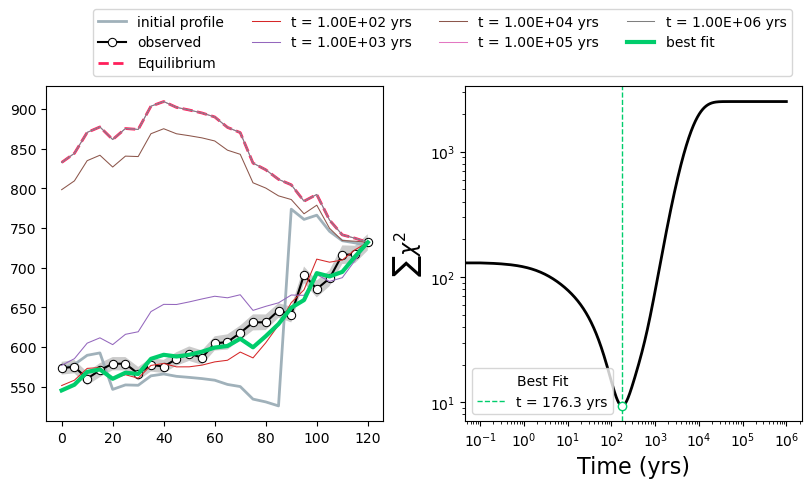

In [7]:
#conversion factor to turn iterations to years
makeyears = 10

fig,ax = plt.subplots(1,2,figsize = (8,4),layout = 'constrained')
compare = [makeyears * 1e2, makeyears * 1e3, makeyears * 1e4,makeyears*1e5,makeyears*1e6]
compare_colors = ["C3", "C4", "C5", "C6","C7"]


ax[0].plot(dist, initial_profile, c = init_color, lw=2, label="initial profile")
ax[0].plot(
    dist,
    te,
    label="observed",
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    mew=0.75,
)
ax[0].fill_between(dist, te + te_unc, te - te_unc,fc = obs_color, alpha=0.2)
ax[0].plot(
    dist, eq_prof, c=dohmen_color, lw=2, ls = '--', label="Equilibrium",)  # boundary conditions

for i in range(0, len(compare)):
    ax[0].plot(
        dist,
        curves[int(compare[i])],
        label="t = {:.2E} yrs".format(compare[i] / makeyears),
        lw=0.75,
        color=compare_colors[i],
    )
    


ax[0].plot(dist, curves[best_fit_iteration], "-", c=bf_color,
           mec="k", lw=3, label="best fit")
h, l = ax[0].get_legend_handles_labels()
fig.legend(h, l, loc="upper left", ncol=len(h)//2, bbox_to_anchor=(0.1, 1.2))


# chi-squared plot
# convert to days
tdays = t / (t[1] - t[0])
x_data = tdays / makeyears
ax[1].plot(
    x_data,
    chi2_array,
    "-k",
    lw=2,
)
# vertical line at best fit value
ax[1].axvline(
    best_fit_iteration / makeyears,
    color=bf_color,
    label="t = {} yrs".format(np.round(best_fit_iteration / makeyears, 2)),
    lw=1,
    ls="--",
)
ax[1].plot(x_data[best_fit_iteration], chi2_array[best_fit_iteration], mfc="w",
        marker="o", ls="", mec=bf_color, mew=1)
ax[1].set_xlabel("time (yrs)", fontsize=16)
ax[1].set_ylabel("$\sum{\chi^2} $", fontsize=16)
ax[1].set_xscale("log")
ax[1].legend(loc="lower left", title="Best Fit", prop={"size": 10})
ax[1].set_yscale("log")
ax[1].set_xlabel("Time (yrs)")




## How long until equilibrium?
To quantify how long it takes for our diffusion model to reach quasi equilibrium we can quantify how similar or dissimilar a model profile is to the calculated quasi equilibrium profile. Furthermore, when the rate of change in this misfit goes to 0 we can infer that we have reached a quasi equilibrium state. Below we show where this is for the above diffusion model. Looking at the above figure it is apparent that it is somewhere between 10<sup>4</sup> and 10<sup>5</sup> years. 

In [8]:
# quantify misfit
eq_misfit = np.sum((curves - eq_prof[None, :] ) ** 2 / curves, axis=1) 
#quantify rate of change for misfit
grad = np.gradient(eq_misfit,t)
# index of first value where rate of change is 0
idx = np.where(grad == 0)[0][0]

Text(0, 0.5, '$\\frac{\\delta \\chi ^2}{\\delta t}$')

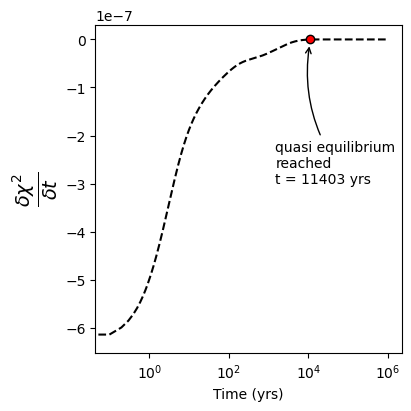

In [9]:
fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(x_data, grad, "k--")
ax.plot(x_data[idx] / makeyears, grad[idx], "ro", mec="k")

ax.annotate(
    f"quasi equilibrium\nreached\nt = {int(x_data[idx]/makeyears)} yrs",
    xy=(x_data[idx] / makeyears, grad[idx]),
    xytext=(1.5e3, -3e-7),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", shrinkB=5),
)
ax.set_xscale("log")
ax.set_xlabel("Time (yrs)")
ax.set_ylabel(r"$\frac{\delta \chi ^2}{\delta t}$", fontsize=20)

## Monte Carlo for diffusion model uncertainty
Here we will randomly vary two things for 1000 iterations to see their impact on our diffusion model:
1. Temperature: this then changes our A value and diffusion coefficient
2. Our analytical profile: This reflects uncertainty in our analyses and how it impacts the diffusion model

For each iteration we will find a best fit diffusion model to the random analytical profile and save it. We'll then get statistics on this distribution and visualize it. 

While technically a change in temperature would change our melt equivalent profile and possibly then our choice of initial profile, this would require a manual choosing of initial condition each iteration of the monte carlo, rendering this sort of exercise not possible. So...for this exercise we leave it the same during each iteration.

In [10]:
best_fits = []
iterations = 1000

for i in tqdm(range(iterations)):
    T = np.random.normal(750, 20)
    RTlngamma, gamma, slope, intercept, stats = plag.dohmen_activity_calc(
        element, an, T, return_regression_stats=True
    )

    c, b, c2 = plag.diffuse_forward_halfspace(
        initial_profile=initial_profile,
        observed_profile=plag.random_profile(te, te_unc),
        timegrid=t,
        diffusivity_profile=plag.plag_diffusivity(
            element=element, an=an, T_K=T + 273.15
        ),
        an_profile=an,
        slope=slope,
        distance_profile=dist,
        temp=T,
        boundary="infinite observed",
        local_minima=False,
    )
    best_fits.append(b)

best_fits = np.array(best_fits)

  0%|          | 0/1000 [00:00<?, ?it/s]

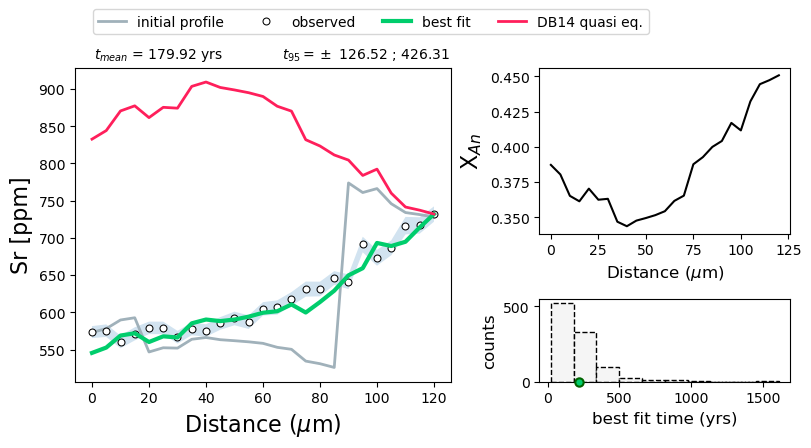

In [11]:
fig, ax = plt.subplot_mosaic(
    [["prof", "an_prof"], ["prof", "hist"]],
    layout="constrained",
    height_ratios=[2, 1],
    width_ratios=[3, 2],
    figsize=(8, 4),
)
fs = 10
ms = 5

ax["prof"].plot(dist, initial_profile, init_color, lw=2, label="initial profile")
ax["prof"].plot(
    dist,
    te,
    label="observed",
    c=obs_color,
    ls="",
    marker="o",
    mfc="w",
    mec=obs_color,
    mew=0.75,
    ms=ms,
)
ax["prof"].fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
ax["prof"].plot(
    dist, curves[best_fit_iteration], "-", c=bf_color, mec="k", lw=3, label="best fit"
)

ax["prof"].plot(
    dist, eq_prof, c=dohmen_color, lw=2, label="DB14 quasi eq."
)  # boundary conditions


ax["prof"].set_xlabel("Distance ($\mu$m)", fontsize=16)
ax["prof"].set_ylabel(f"{element} [ppm]", fontsize=16)


fig.legend(loc="upper left", ncol=4, bbox_to_anchor=(0.1, 1.1))

ax["an_prof"].plot(dist, an, "k-", linewidth=1.5)
ax["an_prof"].set_ylabel("X$_{An}$", fontsize=16)
ax["an_prof"].set_xlabel("Distance ($\mu$m)", fontsize=12)

ax["hist"].hist(
    best_fits / makeyears,
    facecolor="whitesmoke",
    edgecolor="k",
    linestyle="--",
)
ax["hist"].plot(
    best_fits.mean() / makeyears,
    0,
    marker="o",
    mec="darkgreen",
    mfc=bf_color,
    mew=1.5,
    clip_on=False,
    zorder=10,
)
# mpl_defaults.left_bottom_axes(ax["hist"])
ax["hist"].set_xlabel("best fit time (yrs)", fontsize=12)
ax["hist"].set_ylabel("counts", fontsize=12)

transform = "log"

if transform:
    (
        transform_mc_results,
        transform_mean,
        transform_median,
        transform_low,
        transform_high,
    ) = plag.transform_data(best_fits / makeyears, kind=transform)

    ax["prof"].text(
        0.05,
        1.03,
        "$t_{{mean}}$ = {} yrs".format(np.round(transform_mean, 2)),
        transform=ax["prof"].transAxes,
        fontsize=fs,
    )
    ax["prof"].text(
        0.55,
        1.03,
        "$t_{{95}} = \pm$ {} ; {}".format(
            np.round(transform_mean - transform_low, 2),
            np.round(transform_high - transform_mean, 2),
        ),
        transform=ax["prof"].transAxes,
        fontsize=fs,
    )
else:
    ax["prof"].text(
        0.05,
        1.03,
        "$t_{{mean}}$ = {} yrs".format(np.round(best_fits.mean(), 2)),
        transform=ax["prof"].transAxes,
        fontsize=10,
    )
    ax["prof"].text(
        0.55,
        1.03,
        "$t_{{95}} = \pm$ {}".format(np.round(2 * np.std(best_fits), 2)),
        transform=ax["prof"].transAxes,
        fontsize=10,
    )

